# PROJET 4 : Segmentation des clients d'un site e-commerce


## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [CHARGEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
## [MISSION 1: DIFFERENTS TYPES DE SEGMENTATION ](#5)<a class="anchor" id="sommaire"></a>
### [M1-1 : RFM](#6)<a class="anchor" id="sommaire"></a>
### [M1-2 : K-MEANS](#7)<a class="anchor" id="sommaire"></a>
### [M1-3 : DB-SCAN](#8)<a class="anchor" id="sommaire"></a>


--------------------------------------------------------

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from utils.functions import *
import os
from sklearn.cluster import KMeans
from sklearn import preprocessing

## [CHARGEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

In [2]:
### Lecture du fichier de sauvegarde de DF final
file_customers_Final_Behaviour = 'data/final/customers_Final_Behaviour.csv'
file_AllData = 'data/final/AllData.csv'

customers_Final_Behaviour = pd.read_csv(file_customers_Final_Behaviour, sep='\t', engine='python')
all_Data = pd.read_csv(file_AllData, sep='\t', engine='python')

## [MISSION 1: DIFFERENTS TYPES DE SEGMENTATION ](#sommaire)<a class="anchor" id="5"></a>

### [M1-1 : RFM ](#sommaire)<a class="anchor" id="6"></a>

In [ ]:
customers_Final_Behaviour_rfm = customers_Final_Behaviour.copy()
customers_Final_Behaviour_rfm = customers_Final_Behaviour_rfm[['customer_id','recency_order','frequency_order','monetary_amount_order']]
customers_Final_Behaviour_rfm.fillna(0, inplace = True)

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.distplot(customers_Final_Behaviour_rfm['recency_order'], kde_kws={'bw': 0.1})
plt.subplot(3, 3, 2)
sns.distplot(customers_Final_Behaviour_rfm['frequency_order'], kde_kws={'bw': 0.1})
plt.subplot(3, 3, 3)
sns.distplot(customers_Final_Behaviour_rfm['monetary_amount_order'], kde_kws={'bw': 0.1})

#### Scoring en se basant sur les quartiles : 

In [ ]:
# Calcul des score de R
customers_Final_Behaviour_rfm['r_percentile'] = customers_Final_Behaviour_rfm['recency_order'].rank(method='first')
customers_Final_Behaviour_rfm['r_score'] = pd.qcut(customers_Final_Behaviour_rfm['r_percentile'], 4,labels=range(4,0,-1))

# Calcul des score de F
customers_Final_Behaviour_rfm['f_percentile'] = customers_Final_Behaviour_rfm['frequency_order'].rank(method='first')
customers_Final_Behaviour_rfm['f_score'] = pd.qcut(customers_Final_Behaviour_rfm['f_percentile'], 4, labels=range(4,0,-1))

# Calcul des score de M
customers_Final_Behaviour_rfm['m_percentile'] = customers_Final_Behaviour_rfm['monetary_amount_order'].rank(method='first')
customers_Final_Behaviour_rfm['m_score'] = pd.qcut(customers_Final_Behaviour_rfm['m_percentile'], 4, labels=range(4,0,-1))

# Concatenation des scores RFM
customers_Final_Behaviour_rfm['rfm_concat_score'] = customers_Final_Behaviour_rfm['r_score'].astype(str) + customers_Final_Behaviour_rfm['f_score'].astype(str) + customers_Final_Behaviour_rfm['m_score'].astype(str)
# Somme des scores R+F+M
customers_Final_Behaviour_rfm['rfm_score'] = customers_Final_Behaviour_rfm['r_score'].astype(int) + customers_Final_Behaviour_rfm['f_score'].astype(int) + customers_Final_Behaviour_rfm['m_score'].astype(int)

#### Création de la segmentation clients :

Cette segmentation dependra des besoins clients donc à discuter avec le client mais voici une première repartition : 
-  Best Customers -> =444 (A garder imperativement)
-  Loyal Customers -> f_score = 4
-  Big Spenders -> m_score = 4
-  Almost lost -> r_score <= 2 (A relancer)
-  Lost Customers (Bon consommateurs mais perdu -> voir ce qu'on peut faire)
-  Lost Cheap Customers -> 111 (Ne même pas relancer)

In [ ]:
# Créer une nouvelle variable cluster pour determiner les clusters :
customers_Final_Behaviour_rfm['rfm_cluster'] = customers_Final_Behaviour_rfm.apply(rfm_level_type1, axis=1)
#customers_Final_Behaviour_rfm[['rfm_concat_score','rfm_score','rfm_cluster']]

# Faire une transformation inverse de la normalisation faite Log :
customers_Final_Behaviour_rfm_inverse = customers_Final_Behaviour_rfm.copy()
customers_Final_Behaviour_rfm_inverse['frequency_order'] = np.exp(customers_Final_Behaviour_rfm['frequency_order']) - 1
customers_Final_Behaviour_rfm_inverse['monetary_amount_order'] = np.exp(customers_Final_Behaviour_rfm['monetary_amount_order'])-1


In [ ]:
# Calcul des moyennes de chaque rfm_level et la taille de chaque segment 
rfm_level_agg = customers_Final_Behaviour_rfm_inverse.groupby('rfm_cluster').agg({
    'recency_order': 'mean',
    'frequency_order': 'mean',
    'monetary_amount_order': ['mean', 'count']
}).round(1)
# Afficher l'agregation
print(rfm_level_agg)

In [ ]:
# Affichage des repartitions des variables selon les clusters :
cluster_df = customers_Final_Behaviour_rfm_inverse[['recency_order','frequency_order','monetary_amount_order','rfm_cluster']]

radar_plot(cluster_df, group='rfm_cluster', xsize=0.1, ysize=0.05, figsize=(30, 10))

In [ ]:
# Proportions  selon les cluster 
ax = customers_Final_Behaviour_rfm_inverse['rfm_cluster'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Proportion des consommateurs ", fontsize=12)
plt.show()

La frequence n'est pas un très bon parametre car la plupart des consommateurs n'achetent qu'une ou deux fois mais la somme des montants et la recence determinent bien le cluster 

### [M1-2 : K-Means ](#sommaire)<a class="anchor" id="7"></a>

In [3]:
customers_Final_Behaviour_kmeans = customers_Final_Behaviour.copy()

customers_Final_Behaviour_kmeans_in =  customers_Final_Behaviour_kmeans.drop(columns=['Unnamed: 0','customer_id', 'customer_unique_id','customer_city','customer_state','order_id'])
customers_Final_Behaviour_kmeans_in.fillna(0, inplace = True)

#### Standardisation des variables :

In [4]:
customers_Final_Behaviour_kmeans_std = customers_Final_Behaviour_kmeans_in.copy()
# transformer les données en array numpy
X = customers_Final_Behaviour_kmeans_std.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### Determiner les nombres de clusters  avec la methode de Elbow :

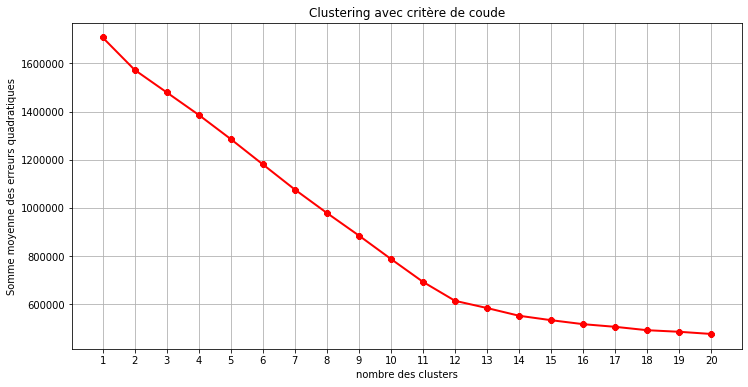

In [5]:
# On caclcule la somme des erreur quadratiques wcss des clusters pour k entre 1 et 20
# choisir la valeur de k ou wcss commence à diminuer (critère du coude)
wcss = []
for k in range(1,21):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    #kmeans.fit(customers_Final_Behaviour_kmeans_in.iloc[:,1:])
    kmeans.fit(X_scaled[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,21),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("nombre des clusters")
plt.xticks(np.arange(1,21,1))
plt.ylabel("Somme moyenne des erreurs quadratiques")
plt.title('Clustering avec critère de coude')
plt.show()

In [6]:
# Selon le "critère du coude" : 
# Décrochement au 12em axe, puis décroissance régulière à partir du 13em axe :
# Donc nos avons ici 12 clusters

#### Générer les clusters :

In [6]:
# Clustering pour n_cluster = 12 
km = KMeans(n_clusters=12)
customers_Final_Behaviour_kmeans_in['kmeans_cluster'] = km.fit_predict(X_scaled[:,1:])

# Faire une transformation inverse de la normalisation faite Log :
customers_Final_Behaviour_kmeans_inverse = customers_Final_Behaviour_kmeans_in.copy()

customers_Final_Behaviour_kmeans_inverse_copy = customers_Final_Behaviour_kmeans_inverse.copy()
listVarDensite = ['frequency_order', 'monetary_amount_order','mean_value_order','nbr_payments_type',
       'amount_sports_leisure', 'amount_health_beauty', 'amount_home',
       'amount_furniture', 'amount_fashion', 'amount_misc',
       'amount_construction', 'amount_electronics', 'amount_supplies',
       'amount_food_drink', 'amount_gifts']
for j,val in enumerate(listVarDensite):
    # transformer les données pour le rendre normales  
    #Les variables qui ont un coeeficient de skewness > 2
    customers_Final_Behaviour_kmeans_inverse_copy[val] =  np.exp(customers_Final_Behaviour_kmeans_inverse[val])-1  
    jmax = j
    
customers_Final_Behaviour_kmeans_inverse_copy.shape

(94862, 20)

#### Repartition des variables pour chaque cluster :

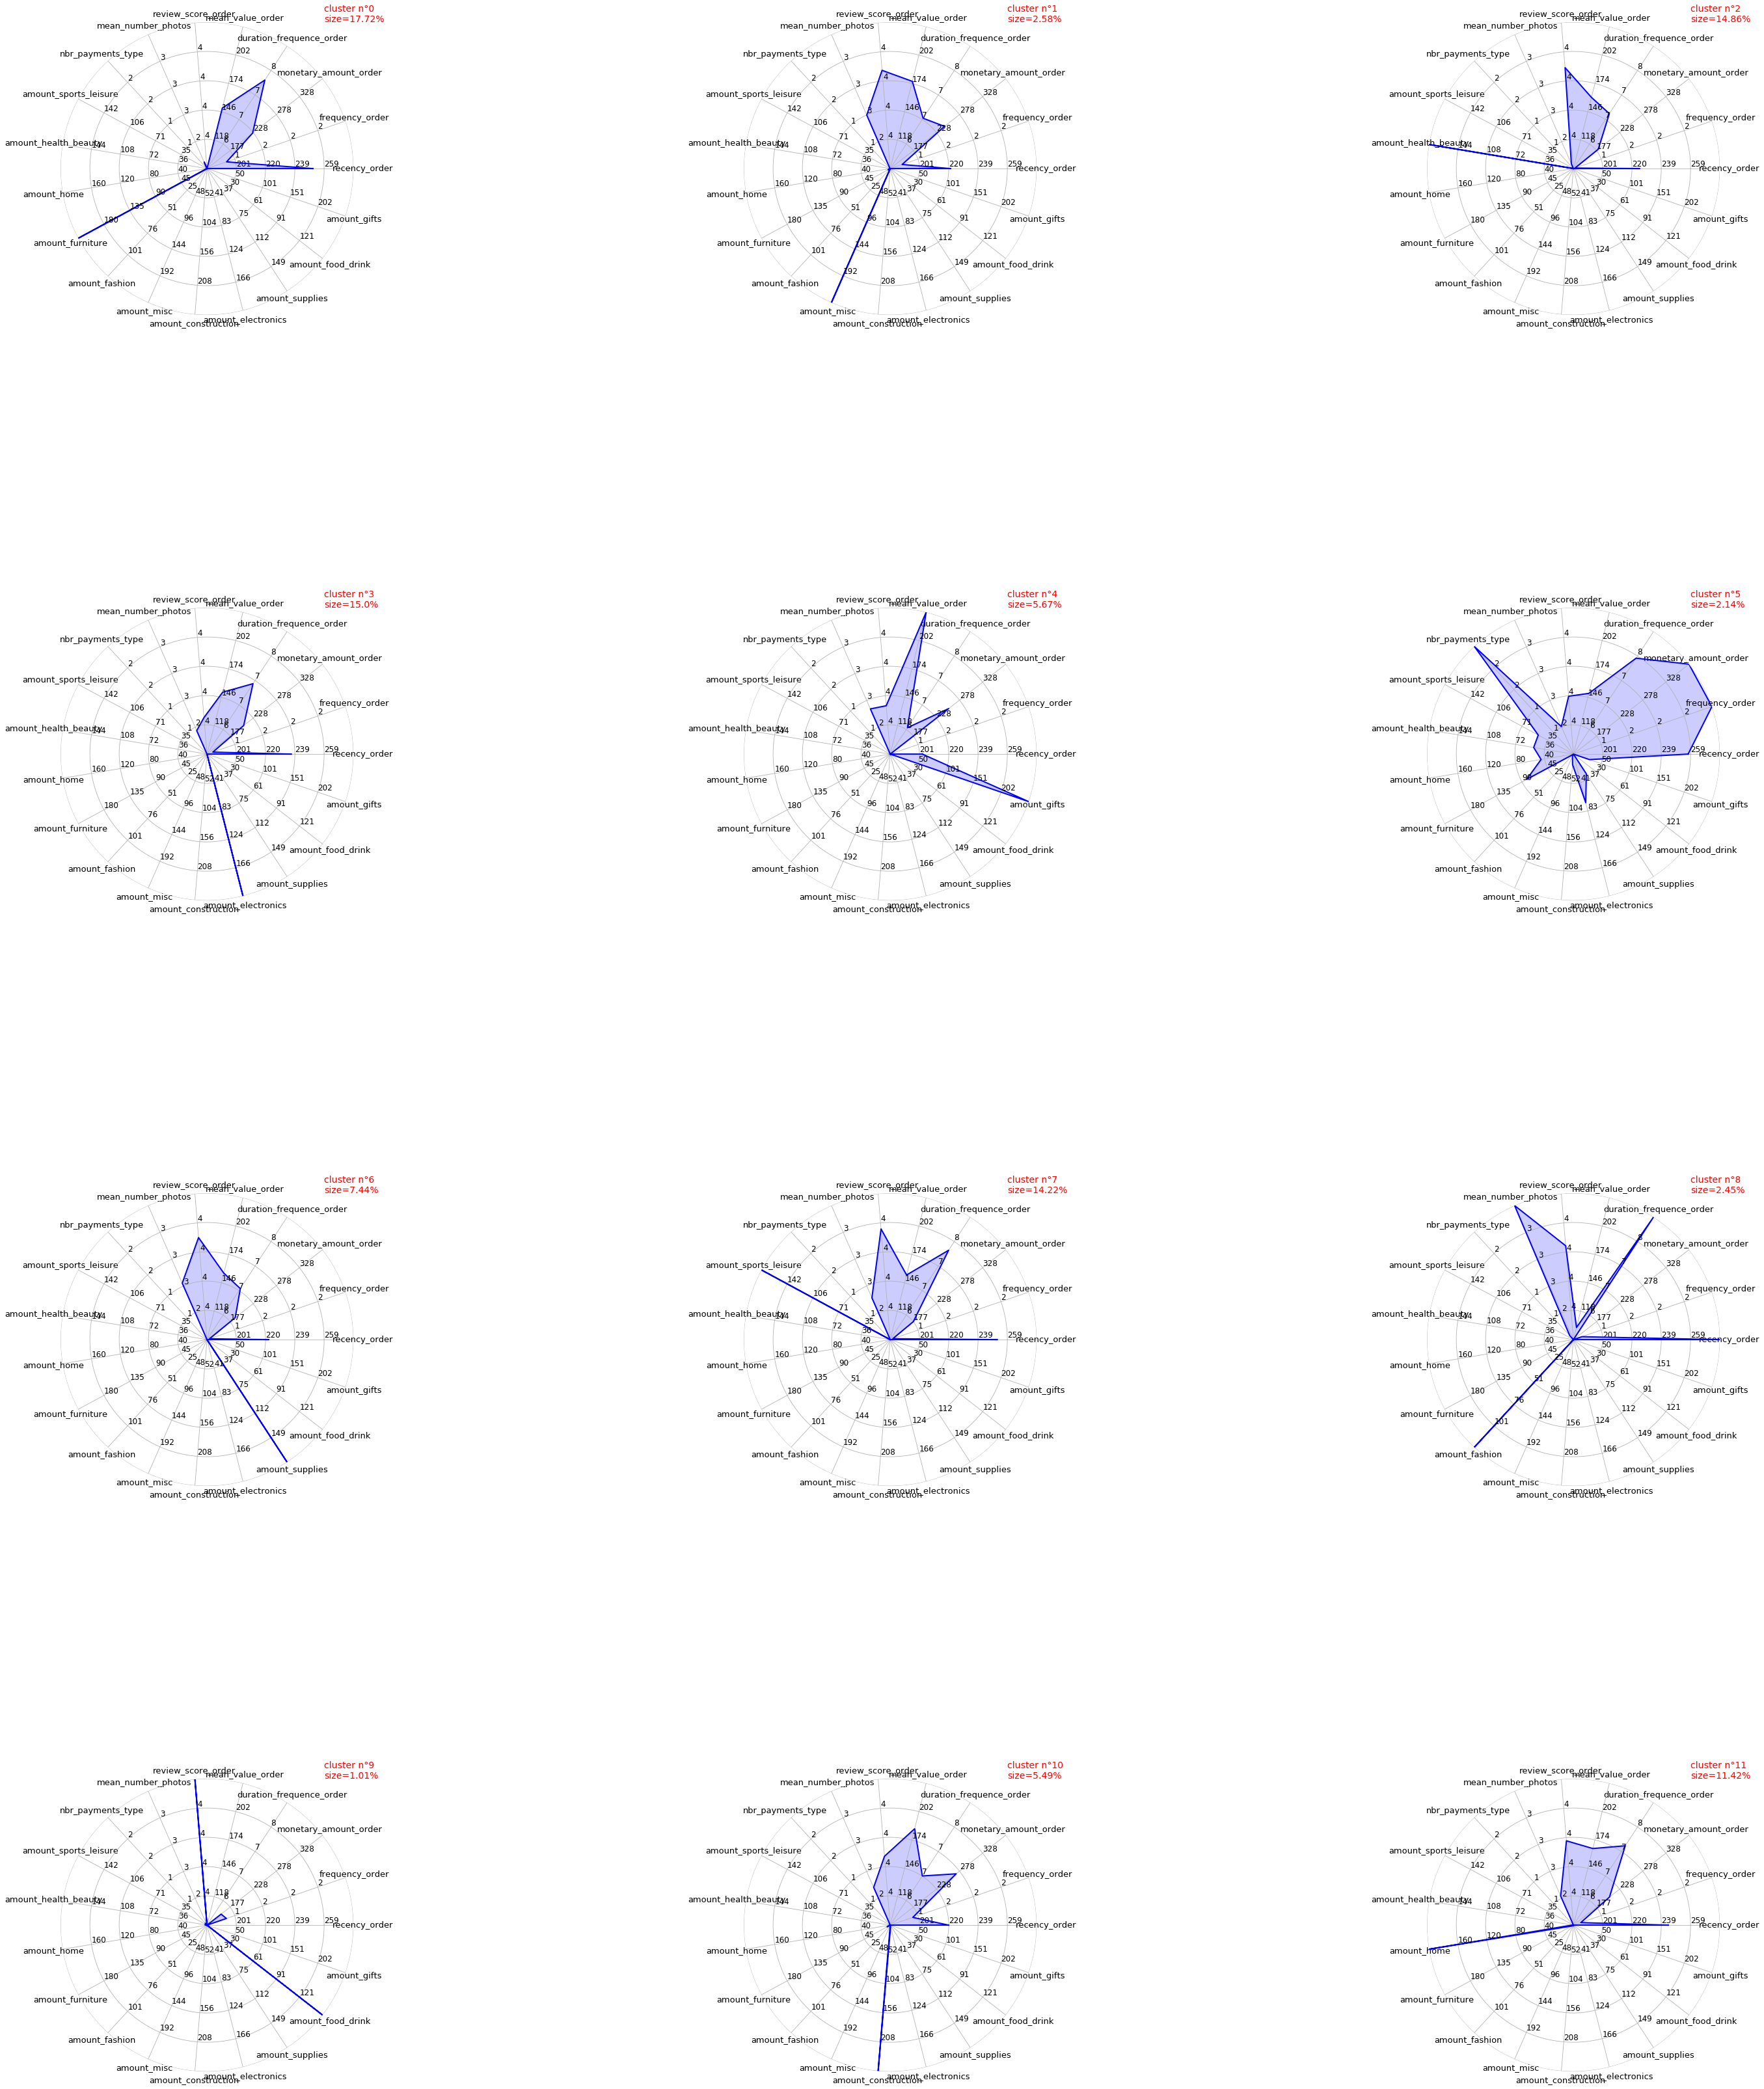

In [14]:
# Affichage des repartitions des variables pour chaque cluster :
radar_plot(customers_Final_Behaviour_kmeans_inverse_copy, group='kmeans_cluster', xsize=0.25, ysize=0.25, figsize=(25,25))

#### Représentation graphique des clusters :

In [10]:
km.fit(X_scaled)
kmeans_cluster = km.predict(X_scaled)

#### Réduction des dimensions pour afficher les clusters :

In [11]:
np.random.seed(1)
#tnse_sample = X_scaled
tnse_sample = customers_Final_Behaviour_kmeans_in

In [12]:
import sklearn.manifold as manifold

# On applique le T-SNE à l'échantillon
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(tnse_sample)

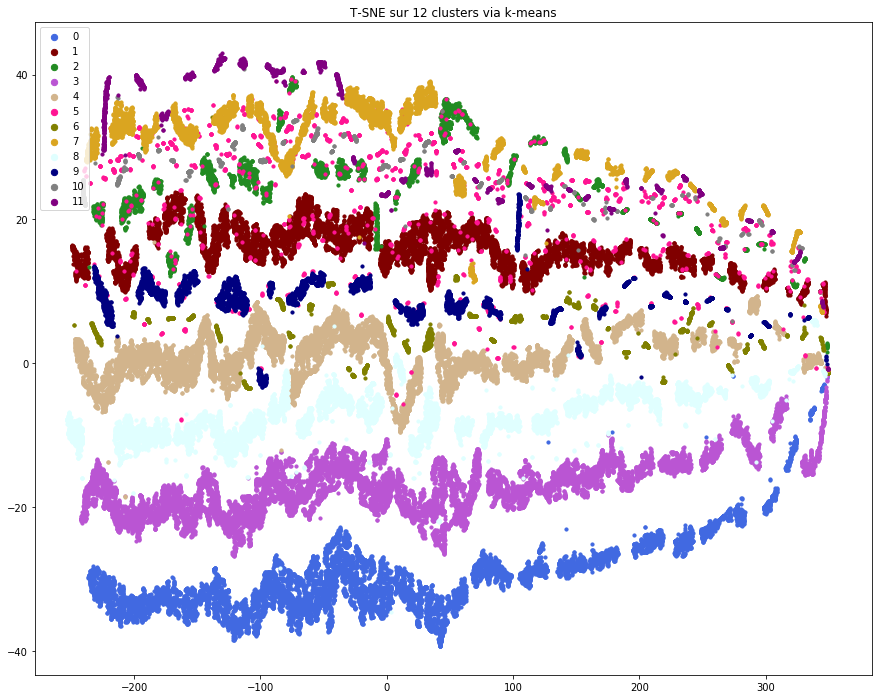

In [14]:
# Affichage du graphique
clusters_sample = kmeans_cluster
plt.figure(figsize=(15, 12))
plt.axis([np.min(X_tsne[:, 0] * 1.1), np.max(X_tsne[:, 0] * 1.1),
          np.min(X_tsne[:, 1] * 1.1), np.max(X_tsne[:, 1] * 1.1)])

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy','gray','purple']

for i in range(len(np.unique(clusters_sample))):
    idx = clusters_sample == i
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=i, s=10, c=colors[i])
    plt.title('T-SNE sur 12 clusters via k-means')

plt.legend(loc='upper left', markerscale=2)
plt.show()

### [M1-3 : DB-Scan ](#sommaire)<a class="anchor" id="8"></a>